# Module Name: SE4050 - Deep Learning Assignment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Group memebr details:**

IT21251900 - Rajapaksha R.M.S.D

IT21302862 - Sri Samadhi L.A.S.S

IT21178054 - Kumari T.A.T.N

IT21360428 - Monali G.M.N.



**Key Objective**

The key objective of this project is to develop a machine learning model using Convolutional Neural Networks (CNN) to accurately identify diseases in potato leaves, specifically Early Blight and Late Blight, and determine if the plant is healthy.

**Methodology**

Supervised Learning

---



This project leverages supervised learning where the model is trained on labeled data—images of potato leaves categorized as Early Blight, Late Blight, or Healthy. This allows the model to learn features associated with each category and make predictions on new, unseen images.

Convolutional Neural Network (CNN)

---



CNNs are well-suited for image classification tasks due to their ability to automatically detect and learn hierarchical patterns like edges, textures, and shapes in images. The model architecture consists of multiple convolutional layers, pooling layers, and fully connected layers, which help in extracting features from the potato leaf images and classifying them into one of the three categories.

Dataset

The dataset used in this project is a Potato Leaf Disease Dataset, which consists of labeled images of potato leaves from three categories,

Early Blight: Leaves affected by the Early Blight disease caused by the fungus Alternaria solani.

Late Blight: Leaves affected by the Late Blight disease caused by the pathogen Phytophthora infestans.

Healthy: Leaves that are not affected by any disease and are classified as healthy.

Link: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

Import data into tensorflow dataset object

In [ ]:
# Verify if the file exists
zip_path = '/content/drive/MyDrive/DL_Project/PlantVillage.zip'
if os.path.exists(zip_path):
    print("File found, proceeding to unzip.")

    # Step 2: Define extraction directory
    extract_to = '/content/PlantVillage/'

    # Step 3: Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"File unzipped to {extract_to}")
else:
    print("File not found, please check the file path.")

File not found, please check the file path.


In [ ]:

import os
import tensorflow as tf

# Step 1: Unzip the file from Google Drive to a local directory
zip_path = '/content/drive/MyDrive/DL_Project/PlantVillage'


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    zip_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


Visualize some of the images from our dataset

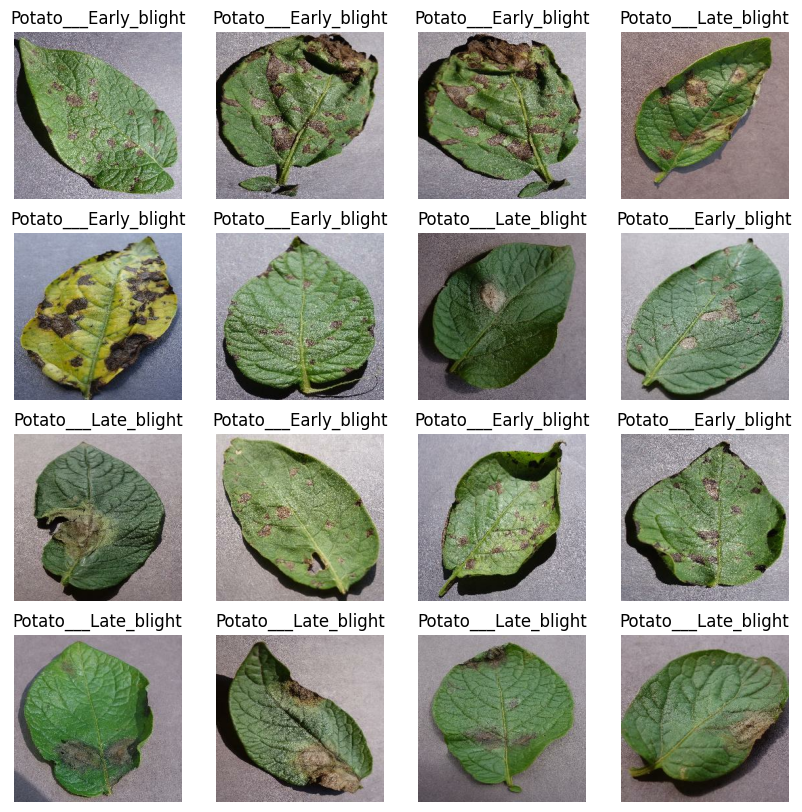

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1) # Changed the grid to 4x4 to accommodate 16 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely: **bold text**

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**IT21302862** - Building the Model

**Creating a Layer for Resizing and Normalization**

Before feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

**Data Augmentation**

This boosts the accuracy of our model by augmenting the data.

In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**IT21302862** - Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

**IT21302862** - Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 562ms/step - accuracy: 0.4374 - loss: 0.9729 - val_accuracy: 0.4896 - val_loss: 0.8992
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.5126 - loss: 0.8793 - val_accuracy: 0.6719 - val_loss: 0.6894
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.7163 - loss: 0.6608 - val_accuracy: 0.6875 - val_loss: 0.6786
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.7853 - loss: 0.4950 - val_accuracy: 0.8021 - val_loss: 0.4807
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.8547 - loss: 0.3676 - val_accuracy: 0.7760 - val_loss: 0.4944
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 352ms/step - accuracy: 0.8757 - loss: 0.3238 - val_accuracy: 0.8646 - val_loss: 0.2869
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9044 - loss: 0.2650 - val_accuracy: 0.8385 - val_loss: 0.3673
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9093 - loss: 0.2496 - val_accu

In [ ]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9600 - loss: 0.1226


In [ ]:
scores

[0.12216389924287796, 0.96484375]

Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

20

In [ ]:
history.history['loss'][:5]

[0.9251284599304199,
 0.8483119010925293,
 0.654913604259491,
 0.46267417073249817,
 0.3312717378139496]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

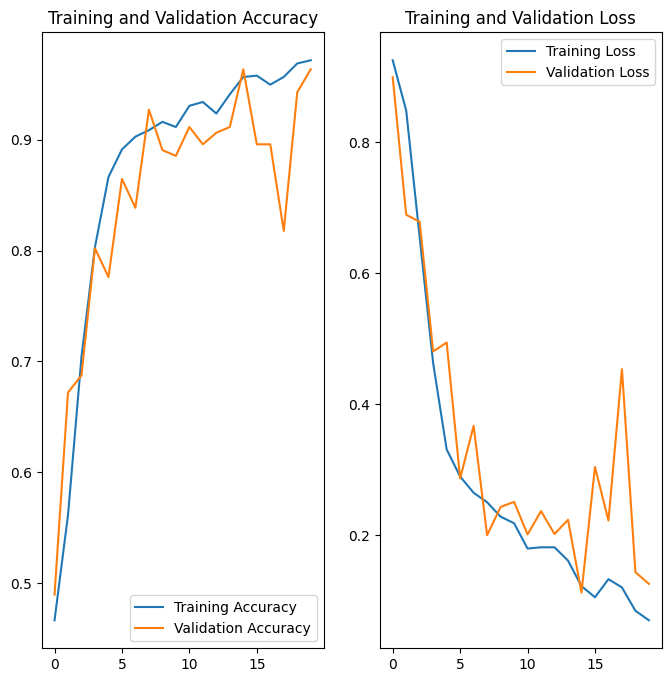

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

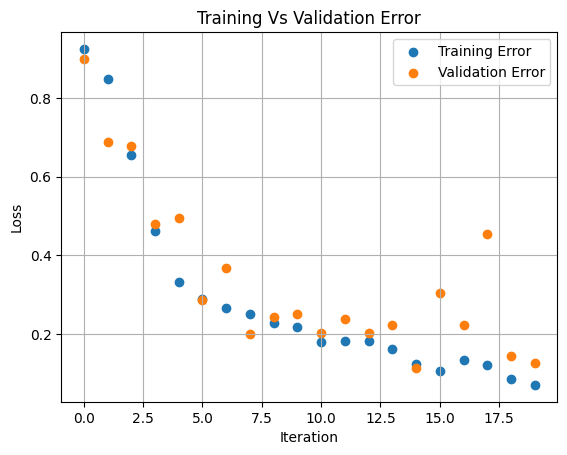

In [ ]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
predicted label: Potato___Early_blight


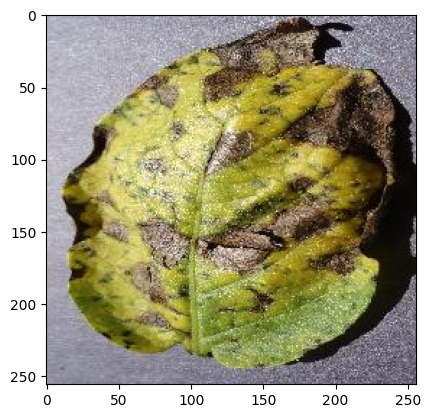

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


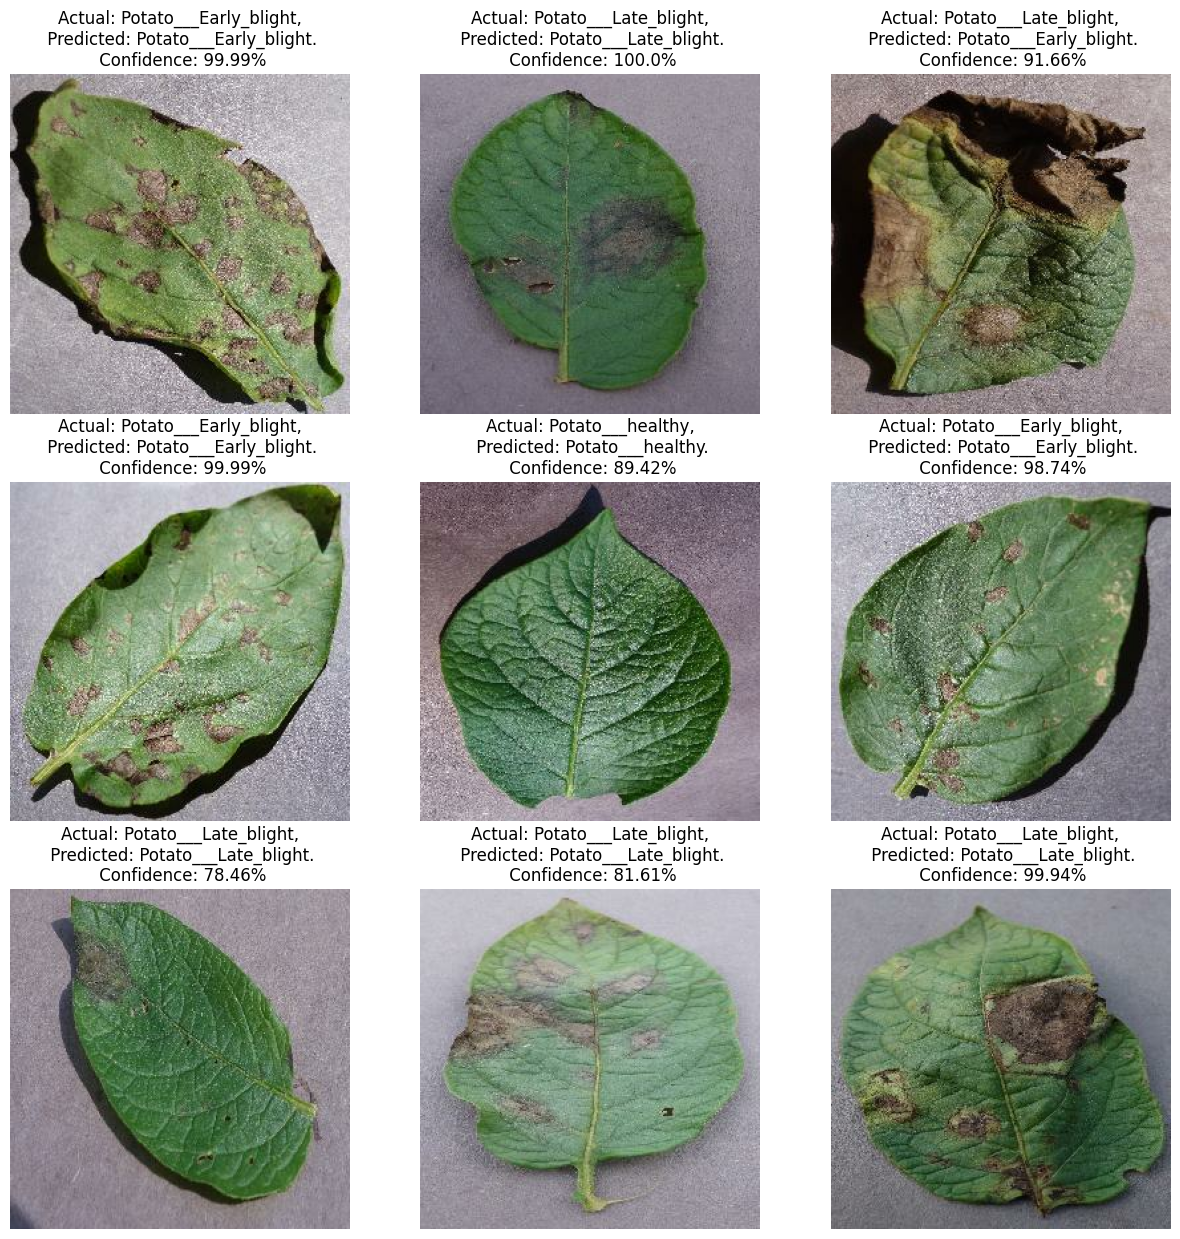

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Saving the Model**

We append the model to the list of models as a new version

In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists("../models"):
    os.makedirs("../models")

# Extract file names without extensions and convert them to integers
model_files = [f for f in os.listdir("../models") if f.endswith(".keras")]
model_versions = [int(f.split('.')[0]) for f in model_files]

# Get the maximum model version, or default to 0 if no models exist
model_version = max(model_versions + [0]) + 1

# Save the new model with the next version number
model.save(f"../models/{model_version}.keras")

In [ ]:
model.save("../potatoes.keras")

In [ ]:
import os

model_path = os.path.abspath(f"../models/{model_version}.keras")
print(f"Model saved at: {model_path}")


Model saved at: /models/1.keras


In [ ]:
import os
print(os.getcwd())

print(os.path.exists("../models"))
!ls /models



/content
True
1.keras


In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


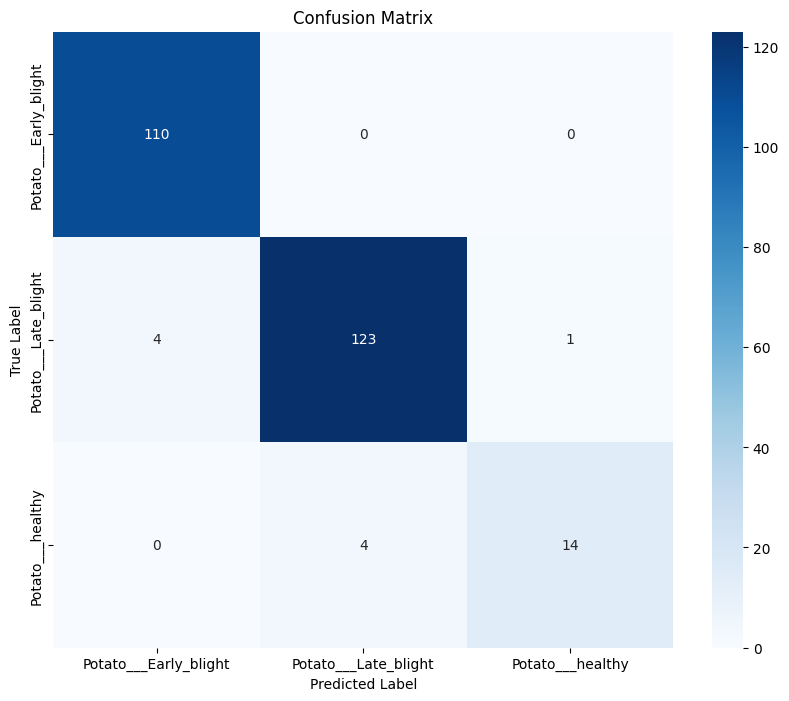

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**IT21251900**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # Import Sequential from tensorflow.keras.models
from tensorflow.keras import layers

resize_and_rescale = Sequential([
    layers.Resizing(224, 224),  # Resize to 224x224 (VGG16 input size)
    layers.Rescaling(1./255),   # Normalize pixel values between 0 and 1
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))) # Changed input_shape to (224, 224, 3)
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Adjusted the architecture to reduce output volume before flattening
model_2.add(Conv2D(256, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(512, (3, 3), activation='relu')) # Added another Conv2D layer
model_2.add(MaxPooling2D(pool_size=(2, 2))) # Added another MaxPooling2D layer


model_2.add(Flatten())
# This dense layer's input shape is adjusted automatically based on the preceding layer
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
num_classes = 10  # Replace 10 with the actual number of classes in your dataset
model_2.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model_2.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,848,202 (18.49 MB)

 Trainable params: 4,848,202 (18.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 325ms/step - accuracy: 0.4273 - loss: 1.5162 - val_accuracy: 0.6875 - val_loss: 0.8954
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.5320 - loss: 0.8966 - val_accuracy: 0.8281 - val_loss: 0.4291
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.8085 - loss: 0.4769 - val_accuracy: 0.6562 - val_loss: 0.8270
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.8032 - loss: 0.5449 - val_accuracy: 0.8385 - val_loss: 0.4719
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.9017 - loss: 0.2426 - val_accuracy: 0.9167 - val_loss: 0.2460
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.9221 - loss: 0.1855 - val_accuracy: 0.8802 - val_loss: 0.3727
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.9544 - loss: 0.1348 - val_accuracy: 0.9427 - val_loss: 0.1006
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.9468 - loss: 0.1540 - val_accu

In [ ]:
scores_2 = model_2.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9427 - loss: 0.1630


In [ ]:

scores_2

[0.15195050835609436, 0.94140625]

In [ ]:

history

In [ ]:

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history.history['loss'])

list

In [ ]:

len(history.history['loss'])

20

In [ ]:
history.history['loss'][:5]

[1.1629000902175903,
 0.7987143993377686,
 0.5354492664337158,
 0.39535999298095703,
 0.22303074598312378]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

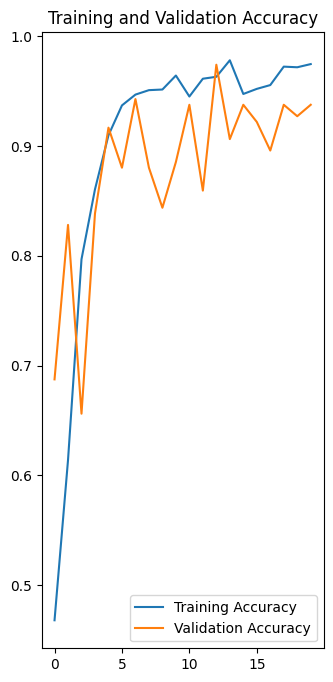

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

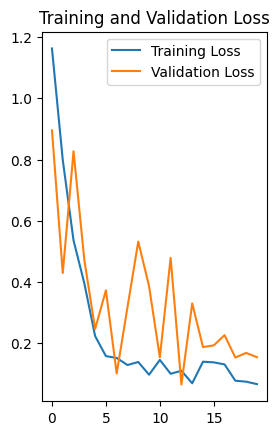

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

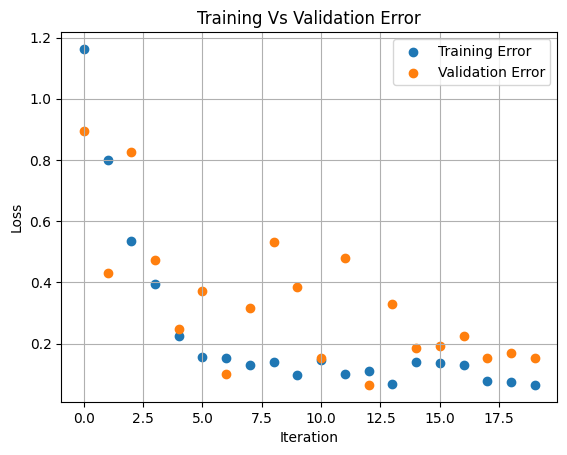

In [ ]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


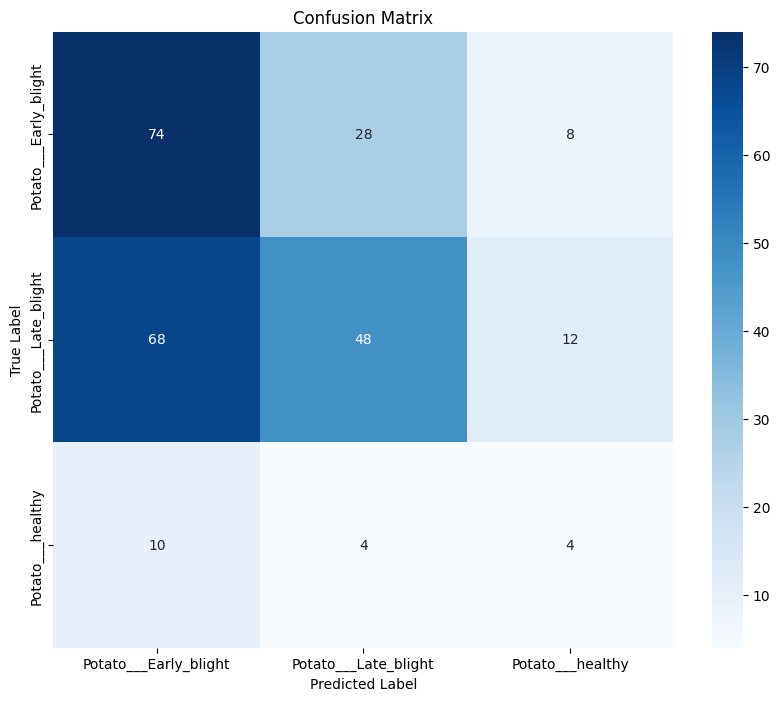

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model_2.predict(images)
    predicted_classes = np.argmax(predictions_2, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# IT21360428

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Data Augmentation (same as Member 1, you can also modify it if necessary)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [ ]:
# Define the image size and number of channels
IMAGE_SIZE = 256
CHANNELS = 3

# You need to manually define class names based on your dataset directory
class_names = ['healthy', 'diseased_class1', 'diseased_class2', 'diseased_class3']  # Modify this according to your dataset

# Set the number of classes
n_classes = len(class_names)

# Define input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define the resize and rescale layers
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

# Define the model
model_4 = models.Sequential([
    resize_and_rescale,  # Use the resize and rescale layer

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the data
    layers.Flatten(),

    # Dense layers with Dropout for regularization
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),  # Output layer with the correct number of classes
])

# Build and summarize the model
model_4.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # Build the model with the correct input shape
model_4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,947,332 (129.50 MB)

 Trainable params: 33,946,372 (129.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Compile the model
model_4.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
# Train the model
history_4 = model_4.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    verbose=1
)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - accuracy: 0.7548 - loss: 12.6915 - val_accuracy: 0.0000e+00 - val_loss: 305.2169
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.8894 - loss: 2.9965 - val_accuracy: 0.0000e+00 - val_loss: 248.3024
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.9175 - loss: 1.5185 - val_accuracy: 0.0000e+00 - val_loss: 189.3594
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9075 - loss: 0.9461 - val_accuracy: 0.4375 - val_loss: 163.2140
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.9306 - loss: 0.4054 - val_accuracy: 0.4375 - val_loss: 142.8623
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.9238 - loss: 0.2549 - val_accuracy: 0.4375 - val_loss: 121.1494
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.9405 - loss: 0.2078 - val_accuracy: 0.4375 - val_loss: 106.3057
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.936

In [ ]:
scores = model_4.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6787 - loss: 3.2157


In [ ]:
scores

[3.2642641067504883, 0.6796875]

In [ ]:
scores

[3.2642641067504883, 0.6796875]

In [ ]:
history_4.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [ ]:
history_4.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history_4.history['loss'])

list

In [ ]:
len(history_4.history['loss'])

20

In [ ]:
history_4.history['loss'][:5]

[8.99852466583252,
 2.6980600357055664,
 1.669994831085205,
 0.6662819385528564,
 0.4060155153274536]

In [ ]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

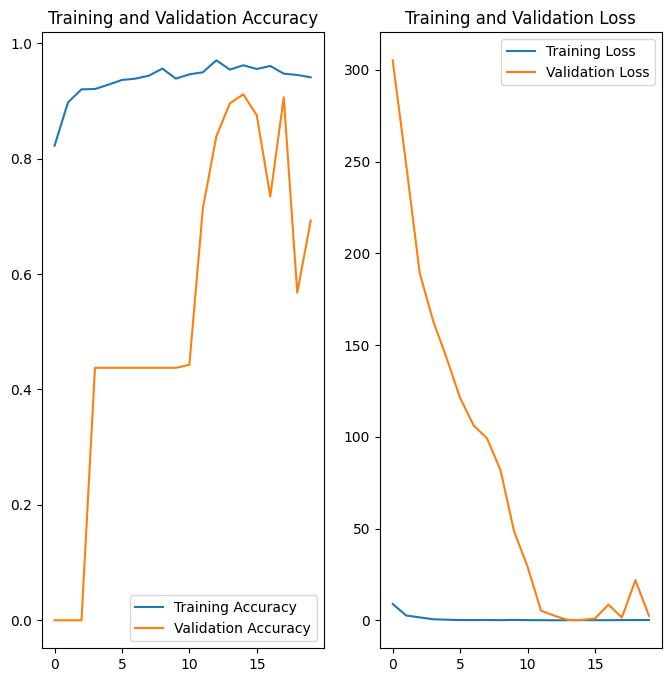

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

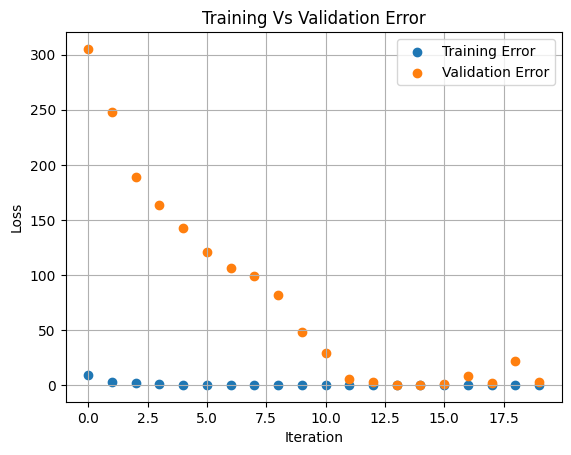

In [ ]:
plt.scatter(x=history_4.epoch,y=history_4.history['loss'],label='Training Error')
plt.scatter(x=history_4.epoch,y=history_4.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics

model_4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


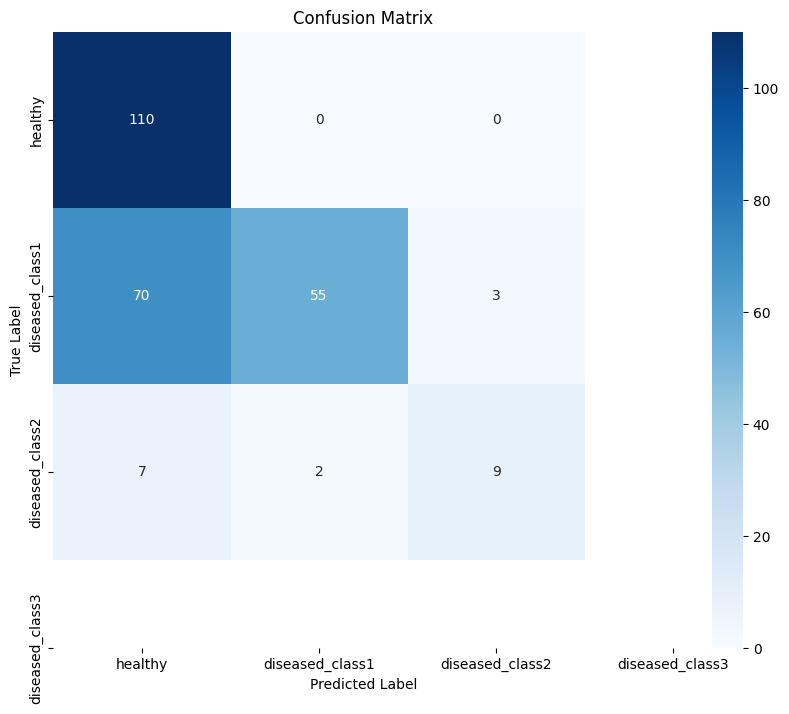

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions_4 = model_4.predict(images)
    predicted_classes_4 = np.argmax(predictions_4, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes_4)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()